# First import all neccessary libraries

I download the dataset from : https://www.kaggle.com/datasets/kshitij192/cars-image-dataset

In [1]:
# Import all system libraries to load images
import os
from pathlib import Path

# To load image using image path
from PIL import Image

# To build default layer which we use repeated using single line
from functools import partial

# Import all general libraries
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf

# To split the data
from sklearn.model_selection import train_test_split

### Load the data from path and create Image dataset using keras

In [2]:
# Set image data path
train_dataset_dir = Path('Cars Dataset/train/')
test_dataset_dir = Path('Cars Dataset/test/')

In [3]:
# How many class/files in dataset
files = os.listdir(train_dataset_dir)
files

['Audi',
 'Hyundai Creta',
 'Mahindra Scorpio',
 'Rolls Royce',
 'Swift',
 'Tata Safari',
 'Toyota Innova']

In [4]:
# Let's check the size of first image
Image.open(os.path.join(train_dataset_dir, files[0]+'/1.jpg')).size

(300, 168)

In [5]:
# Set the batch size and image size to create dataset
batch_size = 32
image_height = 300
image_width = 168

In [6]:
# Create train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    validation_split=0.2,
    subset='training',
    seed= 42,
    image_size = (image_height, image_width),
    batch_size = batch_size 
)

Found 3352 files belonging to 7 classes.
Using 2682 files for training.


In [7]:
# Create validation dataset
valid_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 3352 files belonging to 7 classes.
Using 670 files for validation.


In [8]:
# Create testdataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    seed=42,
    image_size = (image_height, image_width)
)

Found 813 files belonging to 7 classes.


In [9]:
# Create a new list which contain all class names
class_names = train_ds.class_names
print(class_names)

['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


# Visualize data

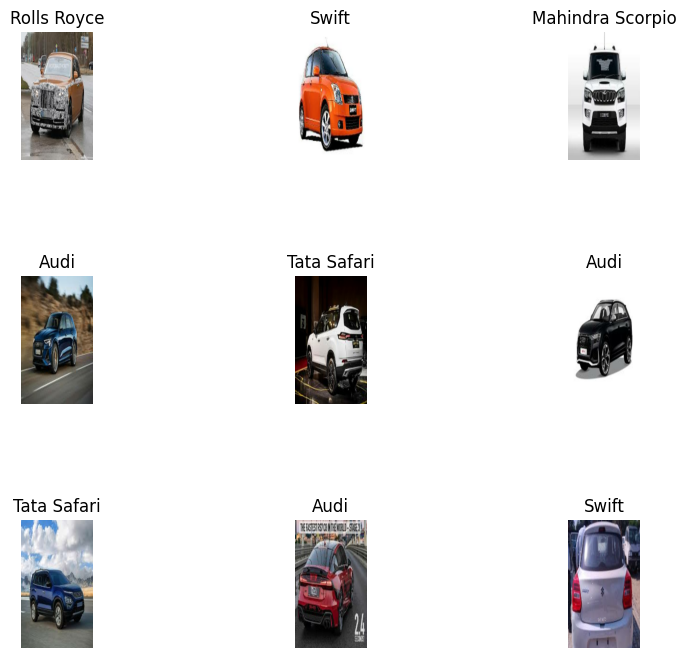

In [10]:
# Let's see some training data

plt.figure(figsize=(10,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.subplots_adjust(hspace=0.9, wspace=0.2)
        plt.axis('off')

In [11]:
# Check the size of image_batch and label_batch
for images_batch, labels_batch in train_ds:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(32, 300, 168, 3)
(32,)


# Standardize the Data

In [12]:
# To normalize the image intensity(which is 0 to 255) to 0 to 1
normalization_layer = tf.keras.layers.Rescaling(1./255)
# And if normalize to -1 to 1 set offset=-1

In [14]:
normalize_train_ds = train_ds.map(lambda X, y: (normalization_layer(X), y))
image_batch, label_batch = next(iter(normalize_train_ds))
first_image = image_batch[0]
# As pixel value should be in range 0 to 1
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [15]:
normalize_valid_ds = valid_ds.map(lambda X, y: (normalization_layer(X), y))

# Configure the dataset for performance

<b>Let's prefetch the data (next batch of data) while we training data (previous batch) in memory already.</b>

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train model

<b>First Let's create ResNet34 model from scratch and use train this model on training dataset !</b>

In [17]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1, padding='same',
                       kernel_initializer='he_normal', use_bias=False)
# Residual Unit
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides>1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
            
        return self.activation(Z + skip_Z)

In [18]:
# Let's build model
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[300, 168,3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
])

prev_filter = 64
for filters in [64] * 3 + [128] * 4+ [256] * 6+ [512] * 3:
    strides = 1 if filters == prev_filter else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filter = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [19]:
# Use 
# sparse_categorical_crossentropy -> to measure the loss
# nadam                           -> for adaptive learn and set the learning rate
# accuracy metric                 -> to check the model's accuracy  
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [22]:
# Set the logdir to visualize training on TensorBoard
run_index = 1
run_logdir = Path() / "car_model_predictions" / "run_{:03d}".format(run_index)
run_logdir

WindowsPath('car_model_predictions/run_001')

In [23]:
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8)
# tensor_board_cb = tf.keras.callbacks.TensorBoard(run_logdir)
history = model.fit(train_ds, validation_data=valid_ds, epochs=2)#, callbacks=[early_stopping_cb, tensor_board_cb])

Epoch 1/2
84/84 [==============================] - 1169s 13s/step - loss: 1.9214 - accuracy: 0.3497 - val_loss: 26.7280 - val_accuracy: 0.1299
Epoch 2/2
84/84 [==============================] - 986s 12s/step - loss: 1.3503 - accuracy: 0.5306 - val_loss: 7.9926 - val_accuracy: 0.1821


As we train model from scratch, so it will take much time as I am training without GPU. 

<b>So, let's use transfer learning now.</b>

### Let's use ResNet50 first

In [24]:
# First preprocess data according to pretrained model (here ResNet50)
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input)
])

In [25]:
train_set = train_ds.map(lambda X,y: (preprocess(X), y))
train_set = train_ds.shuffle(1000, seed=42).batch(batch_size=batch_size).prefetch(1)
valid_set = valid_ds.map(lambda X, y: (preprocess(X), y)).batch(batch_size=batch_size)

### Data Augmentation

<b>We use data augmentation to generate a more images from the dataset we have !</b>

In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

In [27]:
base_model_50 = tf.keras.applications.ResNet50(
    include_top = False,
    weights = 'imagenet'
)

### Add global avg pooling layer and output layer

In [28]:
n_classes = len(class_names)
global_avg = tf.keras.layers.GlobalAveragePooling2D()(base_model_50.output)
output = tf.keras.layers.Dense(n_classes, activation='softmax')(global_avg)

### Then pass it to the model

In [29]:
model_50 = tf.keras.Model(inputs=base_model_50.input, outputs=output)

### Freeze all trained layers in base model

In [30]:
for layer in base_model_50.layers:
    layer.trainable = False

### Finally compile model and start training upto few epochs until new layers learn enough 

In [31]:
model_50.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [32]:
history_50 = model_50.fit(train_ds, validation_data=valid_ds, epochs=5)

Epoch 1/5
84/84 [==============================] - 359s 4s/step - loss: 1.3054 - accuracy: 0.5485 - val_loss: 0.9295 - val_accuracy: 0.6910
Epoch 2/5
84/84 [==============================] - 342s 4s/step - loss: 0.7002 - accuracy: 0.7905 - val_loss: 0.7190 - val_accuracy: 0.7642
Epoch 3/5
84/84 [==============================] - 340s 4s/step - loss: 0.5197 - accuracy: 0.8579 - val_loss: 0.6336 - val_accuracy: 0.7910
Epoch 4/5
84/84 [==============================] - 339s 4s/step - loss: 0.4185 - accuracy: 0.8963 - val_loss: 0.5865 - val_accuracy: 0.8075
Epoch 5/5
84/84 [==============================] - 339s 4s/step - loss: 0.3504 - accuracy: 0.9206 - val_loss: 0.5571 - val_accuracy: 0.8104


<b>This pretrained-model reach great accuracy at few epochs compare to previous model.</b>

### Unfreeze few top pretrained layers and again compile and run it

In [34]:
for layer in base_model_50.layers[56:]:
    layer.trainable = True

### Again comiple and train it again after unfreeze few top pretrained layers

In [37]:
# Set learning rate very low to let learn freezed layers 
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)

In [38]:
model_50.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [39]:
model_50.fit(train_ds, validation_data=valid_ds, epochs=5)

Epoch 1/5
84/84 [==============================] - 755s 9s/step - loss: 0.5401 - accuracy: 0.8218 - val_loss: 0.6001 - val_accuracy: 0.8149
Epoch 2/5
84/84 [==============================] - 560s 7s/step - loss: 0.1292 - accuracy: 0.9866 - val_loss: 0.4054 - val_accuracy: 0.8701
Epoch 3/5
84/84 [==============================] - 554s 7s/step - loss: 0.0549 - accuracy: 0.9989 - val_loss: 0.3616 - val_accuracy: 0.8925
Epoch 4/5
84/84 [==============================] - 550s 7s/step - loss: 0.0305 - accuracy: 0.9996 - val_loss: 0.3451 - val_accuracy: 0.8985
Epoch 5/5
84/84 [==============================] - 552s 7s/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.3352 - val_accuracy: 0.9030


As there is overfitting, we can balance this by adding normalization like Dropout layer, because this is pretrained layer, so it easy to add <b> dropout layer </b> in last.
So, we add last dropout layer, and set rate 40-50% (which is preferable for CNN)

In [44]:
# After applying only dropout layer, result:
history_50 = model_50.fit(train_ds, validation_data=valid_ds, epochs=5)

Epoch 1/5
84/84 [==============================] - 196s 2s/step - loss: 0.7039 - accuracy: 0.7655 - val_loss: 0.3939 - val_accuracy: 0.8716
Epoch 2/5
84/84 [==============================] - 205s 2s/step - loss: 0.1169 - accuracy: 0.9653 - val_loss: 0.4097 - val_accuracy: 0.8791
Epoch 3/5
84/84 [==============================] - 208s 2s/step - loss: 0.0589 - accuracy: 0.9825 - val_loss: 0.4011 - val_accuracy: 0.8791
Epoch 4/5
84/84 [==============================] - 205s 2s/step - loss: 0.0411 - accuracy: 0.9914 - val_loss: 0.3812 - val_accuracy: 0.8896
Epoch 5/5
84/84 [==============================] - 212s 3s/step - loss: 0.0271 - accuracy: 0.9929 - val_loss: 0.3841 - val_accuracy: 0.8940


This is also don't solve our problem very much.So, 

I also add <b>Weight Regularization l2</b>, to reuce some complexity.

In [45]:
global_avg = tf.keras.layers.GlobalAveragePooling2D()(base_model_50.output)

dense_layer = tf.keras.layers.Dense(256, activation='relu', kernel_initializer = 'he_normal',
                                   kernel_regularizer=tf.keras.regularizers.l2(0.01))(global_avg)
dropout_layer = tf.keras.layers.Dropout(rate=.5)(dense_layer)

output = tf.keras.layers.Dense(n_classes, activation='softmax',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_layer)
model_50 = tf.keras.Model(inputs=base_model_50.input, outputs=output)

And when you add a dropout layer or any other new layers to your model, it's a good practice to freeze the weights of the pretrained layers again. This ensures that during the training of your new model, only the weights of the newly added layers are updated, and the weights of the pretrained layers remain fixed.

### So freeze all trained layers again in base model

In [46]:
for layer in base_model_50.layers:
    layer.trainable = False

### Then compile model again and start training upto few epochs until new layers learn enough 

In [47]:
model_50.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [48]:
history_50 = model_50.fit(train_ds, validation_data=valid_ds, epochs=5)

Epoch 1/5
84/84 [==============================] - 198s 2s/step - loss: 4.5758 - accuracy: 0.7789 - val_loss: 3.1419 - val_accuracy: 0.8687
Epoch 2/5
84/84 [==============================] - 208s 2s/step - loss: 2.1311 - accuracy: 0.9605 - val_loss: 1.8022 - val_accuracy: 0.8910
Epoch 3/5
84/84 [==============================] - 205s 2s/step - loss: 1.1778 - accuracy: 0.9802 - val_loss: 1.1652 - val_accuracy: 0.8866
Epoch 4/5
84/84 [==============================] - 203s 2s/step - loss: 0.7032 - accuracy: 0.9870 - val_loss: 0.9007 - val_accuracy: 0.8851
Epoch 5/5
84/84 [==============================] - 210s 3s/step - loss: 0.5128 - accuracy: 0.9821 - val_loss: 0.7971 - val_accuracy: 0.8716


### Unfreeze few top pretrained layers and again compile and run it

In [49]:
for layer in base_model_50.layers[56:]:
    layer.trainable = True

### Again comiple and train it after unfreeze few top pretrained layers

In [50]:
# Set learning rate very low to let learn freezed layers 
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)

In [51]:
model_50.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [52]:
model_50.fit(train_ds, validation_data=valid_ds, epochs=5)

Epoch 1/5
84/84 [==============================] - 590s 7s/step - loss: 0.4343 - accuracy: 0.9903 - val_loss: 0.6756 - val_accuracy: 0.9060
Epoch 2/5
84/84 [==============================] - 558s 7s/step - loss: 0.3826 - accuracy: 0.9993 - val_loss: 0.6513 - val_accuracy: 0.9090
Epoch 3/5
84/84 [==============================] - 561s 7s/step - loss: 0.3639 - accuracy: 1.0000 - val_loss: 0.6436 - val_accuracy: 0.9194
Epoch 4/5
84/84 [==============================] - 558s 7s/step - loss: 0.3544 - accuracy: 0.9996 - val_loss: 0.6230 - val_accuracy: 0.9164
Epoch 5/5
84/84 [==============================] - 558s 7s/step - loss: 0.3429 - accuracy: 1.0000 - val_loss: 0.6077 - val_accuracy: 0.9239


# After all set, we save model


In [53]:
model_50.save('CarsModelPrediction_Model_ResNet50.h5')

D:\AnaConda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Let's load model and check accuracy with on test dataset (unseen data)

In [54]:
new_model = tf.keras.saving.load_model('CarsModelPrediction_Model_ResNet50.h5')
# tf.keras.models.save_model(new_model, 'ResNet50_On_car.keras', save_format='keras')

In [55]:
y_pred = new_model.evaluate(test_ds)

26/26 [==============================] - 46s 2s/step - loss: 0.5328 - accuracy: 0.9348


<b>It give around 93% accuracy which is not bad !</b>

# Now, let's check a confusion matrics

In [56]:
images, labels = next(iter(test_ds))

In [57]:
actual_classes = []
for i in labels:
    actual_classes.append(class_names[i])

In [58]:
predicted_classes_proba = new_model.predict(images)

1/1 [==============================] - 3s 3s/step


In [59]:
predicted_classes = []
for i in range(len(predicted_classes_proba)):
    predicted_classes.append(class_names[np.argmax(predicted_classes_proba[i])])

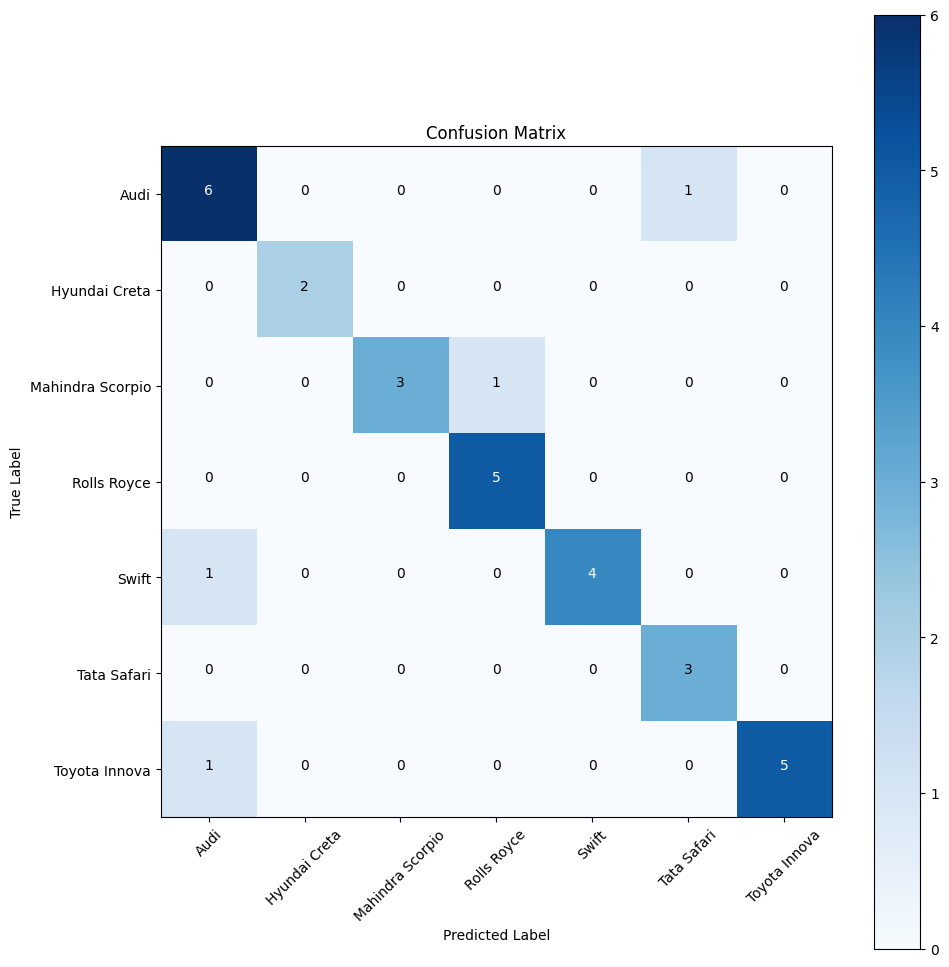

In [60]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_mark = np.arange(len(class_names))
plt.xticks(tick_mark, class_names, rotation=45)
plt.yticks(tick_mark, class_names)
thresh = cm.max() / 2

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Check on random images which I download from google.

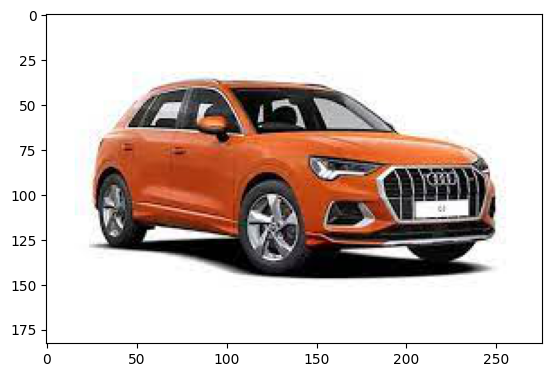

In [69]:
img = np.array(Image.open('test_5.jpeg'))
plt.imshow(img)

In [70]:
img = tf.reshape(img, [-1, img.shape[0], img.shape[1], img.shape[2]])
y_proba = new_model.predict(img)

1/1 [==============================] - 1s 1s/step


In [71]:
class_ = ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
class_[np.argmax(y_proba)]

'Audi'

In [72]:
(np.max(y_proba)*100).round(2)

99.86

<b>It is 99% sure that, given image is of Audi !</b>

This is my Car model prediction project !

# Thank you !